In [25]:
import pandas as pd

In [ ]:
import pickle
import sys
import os

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join("../..")))  # if you're in optimizer/

with open("../parameters/simulation_parameters.pkl", "rb") as f:
    sim_params = pickle.load(f)

simulated_logs = pd.read_csv("../../simulated_log.csv")
logs = pd.read_csv("../../raw_data/LoanApp.csv.gz", compression='gzip')

Agent timelines

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.cm as cm

def plot_agent_timeline_by_case(df, agent_id):
    df = df.copy()
    df['start'] = pd.to_datetime(df['start'], format='mixed', utc=True)
    df['end'] = pd.to_datetime(df['end'], format='mixed', utc=True)
    df = df[df['agent'] == agent_id].sort_values('start')

    case_ids = df['case_id'].unique()
    activity_types = df['activity'].unique()

    cmap = cm.get_cmap('tab20', len(activity_types))
    activity_to_color = {act: cmap(i) for i, act in enumerate(activity_types)}
    case_to_y = {case: i for i, case in enumerate(case_ids)}

    fig, ax = plt.subplots(figsize=(14, len(case_ids) * 0.4 + 2))

    for _, row in df.iterrows():
        y = case_to_y[row['case_id']]
        color = activity_to_color[row['activity']]
        ax.hlines(y, xmin=row['start'], xmax=row['end'],
                  linewidth=6, color=color, alpha=0.9)

    ax.set_yticks(list(case_to_y.values()))
    ax.set_yticklabels([f"Case {cid}" for cid in case_ids])
    ax.set_xlabel("Time")
    ax.set_title(f"Agent {agent_id} Activity Timeline by Case")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in activity_to_color.values()]
    labels = list(activity_to_color.keys())
    ax.legend(handles, labels, title="Activity", bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


/var/folders/x3/5rg2fq097snf05l9glzskh9r0000gn/T/ipykernel_66156/731271094.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(activity_types))


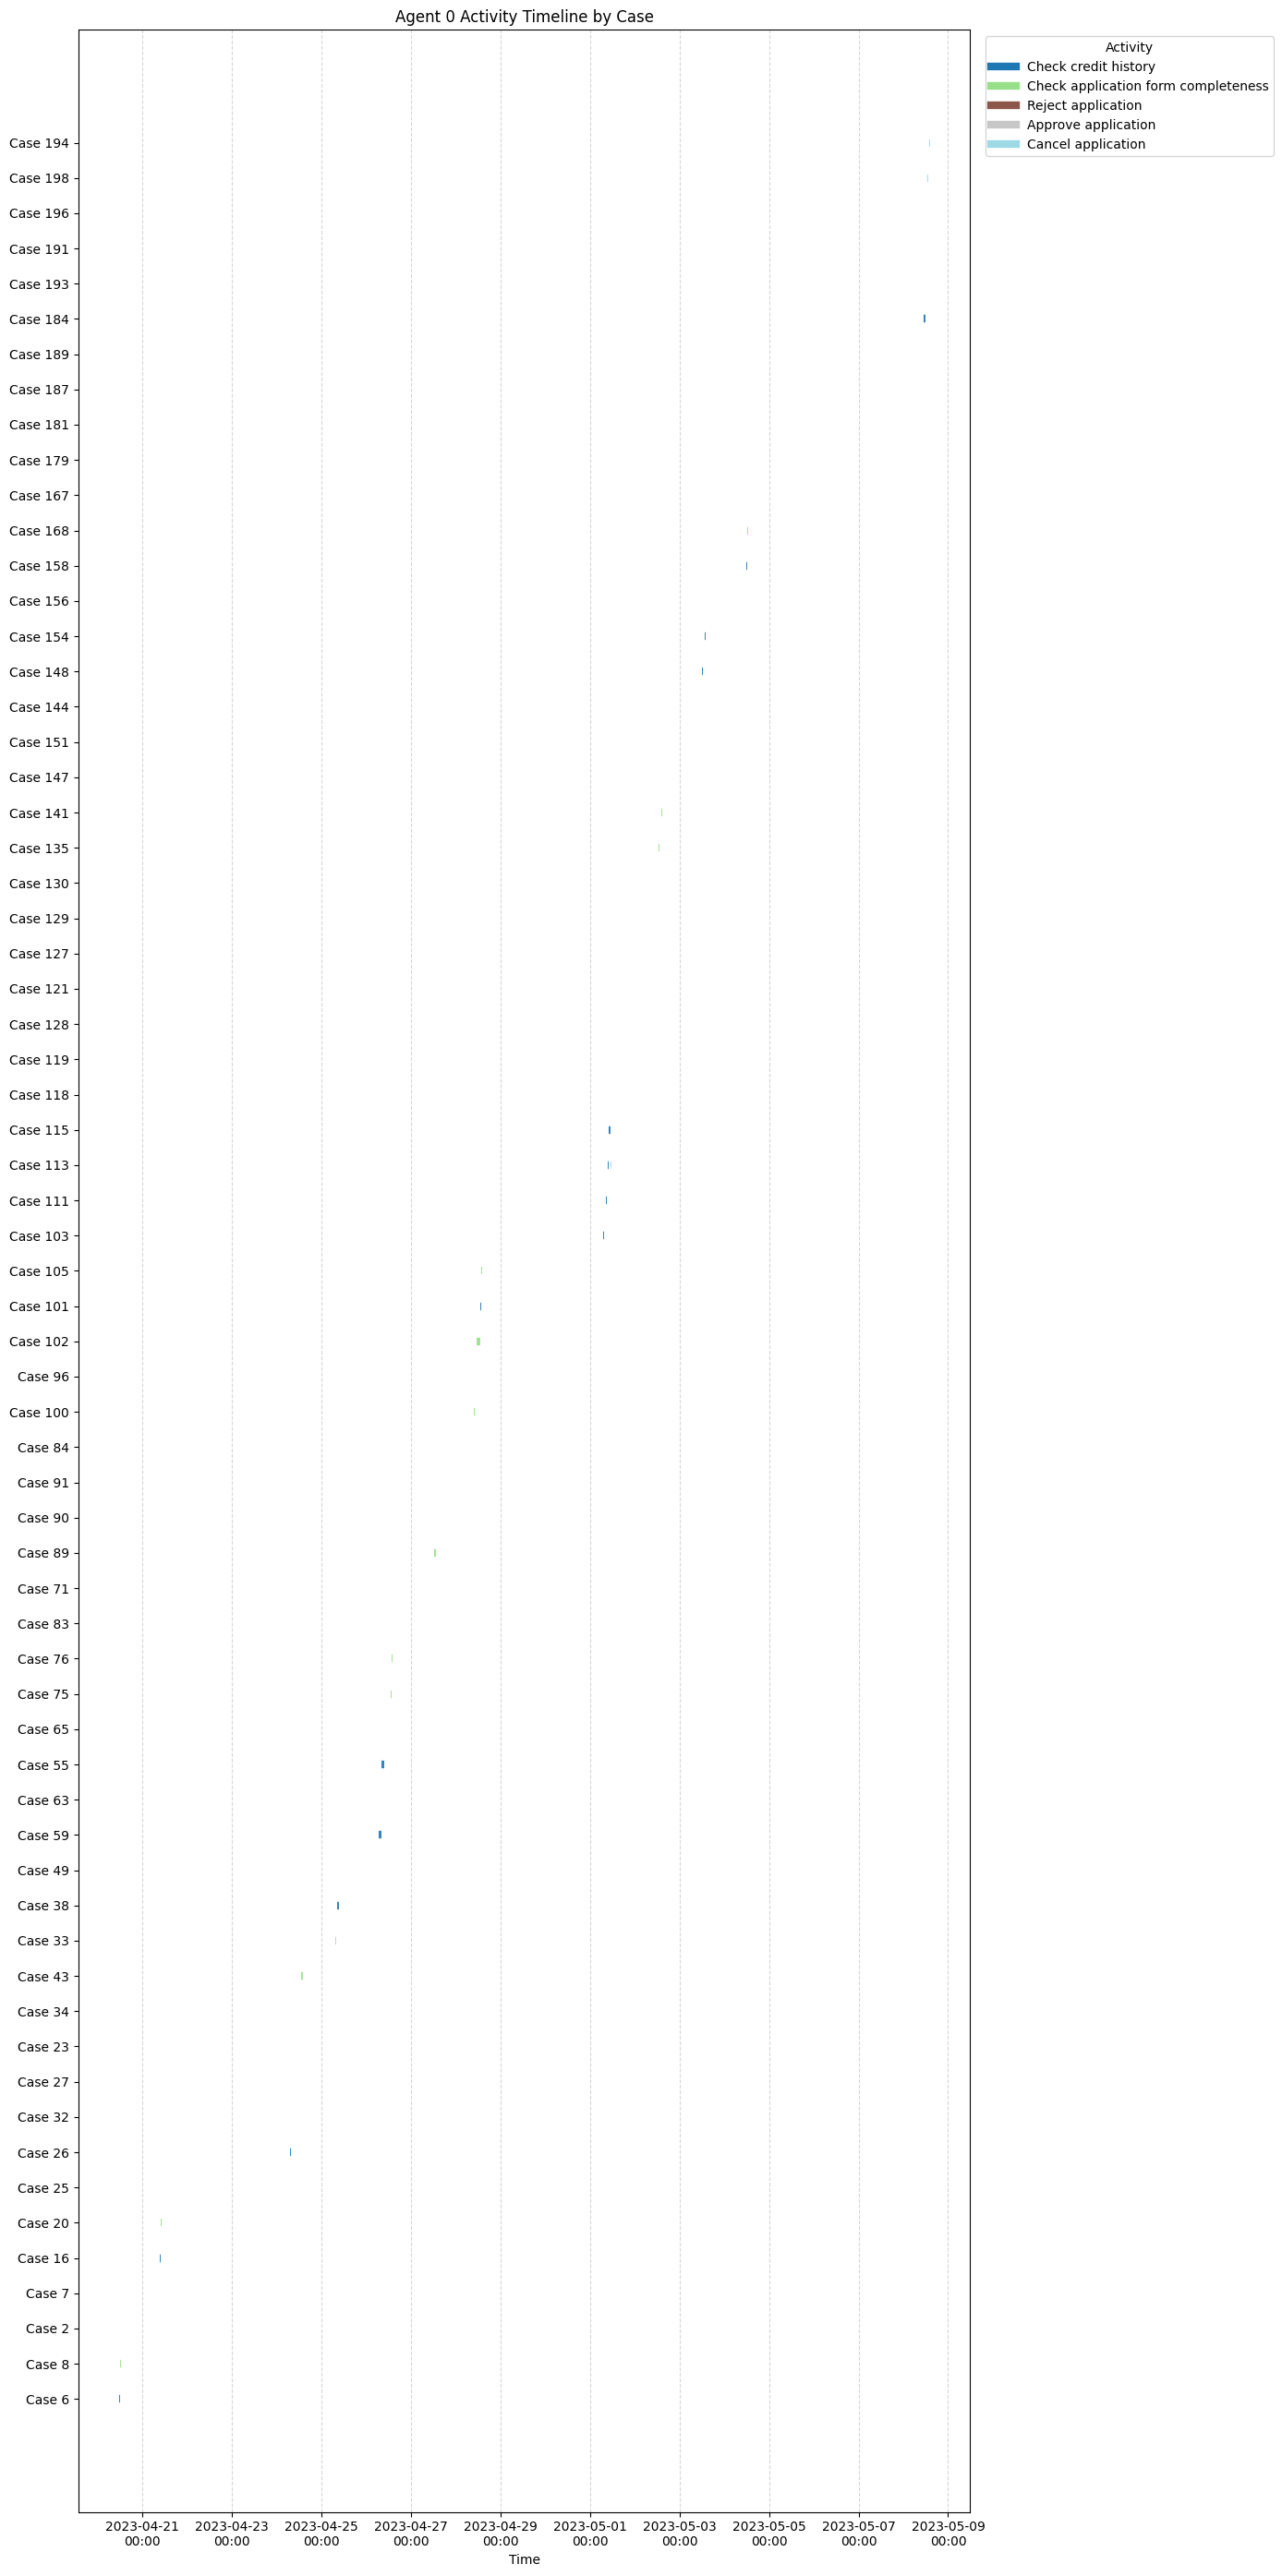

In [ ]:
plot_agent_timeline_by_case(simulated_logs, agent_id=0)

Validation checks

In [30]:
from collections import defaultdict
import pandas as pd
import math
import scipy.stats as st
from datetime import datetime, timedelta

In [31]:
def sample_from_distribution(distribution):
    """
    Copy of the AgentSimulator utils method
    """
    if distribution.type.value == "expon":
        scale = distribution.mean - distribution.min
        if scale < 0.0:
            print("Warning! Trying to generate EXPON sample with 'mean' < 'min', using 'mean' as scale value.")
            scale = distribution.mean
        sample = st.expon.rvs(loc=distribution.min, scale=scale, size=1)
    elif distribution.type.value == "gamma":
        # If the distribution corresponds to a 'gamma' with loc!=0, the estimation is done wrong
        # dunno how to take that into account
        sample = st.gamma.rvs(
            pow(distribution.mean, 2) / distribution.var,
            loc=0,
            scale=distribution.var / distribution.mean,
            size=1,
        )
    elif distribution.type.value == "norm":
        sample = st.norm.rvs(loc=distribution.mean, scale=distribution.std, size=1)
    elif distribution.type.value == "uniform":
        sample = st.uniform.rvs(loc=distribution.min, scale=distribution.max - distribution.min, size=1)
    elif distribution.type.value == "lognorm":
        # If the distribution corresponds to a 'lognorm' with loc!=0, the estimation is done wrong
        # dunno how to take that into account
        pow_mean = pow(distribution.mean, 2)
        phi = math.sqrt(distribution.var + pow_mean)
        mu = math.log(pow_mean / phi)
        sigma = math.sqrt(math.log(phi ** 2 / pow_mean))
        sample = st.lognorm.rvs(sigma, loc=0, scale=math.exp(mu), size=1)
    elif distribution.type.value == "fix":
        sample = [distribution.mean] * 1

    return sample[0]

def remove_transitive_response_constraints(response_constraints):
    cleaned = {}

    for act, responses in response_constraints.items():
        direct = set(responses)

        # Remove any activity that is indirectly reachable through other responses
        for mid in responses:
            indirects = set(response_constraints.get(mid, []))
            direct -= indirects

        cleaned[act] = list(direct)

    return cleaned


def discover_post_conditions(df, activity_col='activity', case_col='case_id', order_by='end_time'):
    response_counts = defaultdict(lambda: defaultdict(int))
    activity_counts = defaultdict(int)

    # Group by case
    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()

        for i, act in enumerate(sorted_activities):
            activity_counts[act] += 1

            # All activities that come after this one
            for after_act in sorted_activities[i+1:]:
                response_counts[act][after_act] += 1

    # Build final response constraint map
    post_conditions = {}
    for act, after_acts in response_counts.items():
        constraints = []
        for after_act, count in after_acts.items():
            # Threshold: e.g., B happens after A in 80%+ of A occurrences
            if count / activity_counts[act] >= 0.8:
                constraints.append(after_act)
        if constraints:
            post_conditions[act] = constraints

    post_conditions = remove_transitive_response_constraints(post_conditions)

    return post_conditions


def extract_all_successors(transition_dict):
    """
    Converts a nested transition dictionary to a flat mapping:
    prefix_activity → list of all possible successor activities (non-zero prob)

    Parameters:
    - transition_dict: dict of {prefix: {agent_id: {activity: prob}}} ! Careful, only one activity prefixes are valid

    Returns:
    - dict of {activity: [possible next activities]}
    """
    flat_successors = {}
    seen_anchors = set()

    for prefix, agent_dict in transition_dict.items():
        if not prefix:
            continue  # skip empty prefixes
        if prefix[-1] in seen_anchors:
            continue
        anchor = prefix[-1]  # last activity in the prefix
        seen_anchors.add(anchor)

        successor_set = set()
        for agent_transitions in agent_dict.values():
            for act, prob in agent_transitions.items():
                if prob > 0:
                    successor_set.add(act)

        flat_successors[anchor] = sorted(successor_set)

    return flat_successors


def mine_concurrent_activities(df, case_col='case_id', activity_col='activity',
                                start_col='start_time', end_col='end_time'):
    """
    For each activity, detect other activities that can run concurrently
    by overlapping time windows in the same case.

    Parameters:
    - df: Event log with case_id, activity, start_time, end_time

    Returns:
    - co_occurrence: dict {activity: [other activities that overlapped with it]}
    """
    df = df.copy()
    df[start_col] = pd.to_datetime(df[start_col], format='mixed', utc=True)
    df[end_col] = pd.to_datetime(df[end_col], format='mixed', utc=True)


    co_occurrence = defaultdict(set)

    for case_id, group in df.groupby(case_col):
        group = group.sort_values(by=start_col)
        for i, row_i in group.iterrows():
            act_i, start_i, end_i = row_i[activity_col], row_i[start_col], row_i[end_col]
            for j, row_j in group.iterrows():
                if i == j:
                    continue
                act_j, start_j, end_j = row_j[activity_col], row_j[start_col], row_j[end_col]
                # Check for overlap
                if start_i < end_j and start_j < end_i:
                    co_occurrence[act_i].add(act_j)

    # Convert sets to sorted lists
    return {act: sorted(list(others)) for act, others in co_occurrence.items()}

def extract_xor_groups_from_cooccurrence(successor_map, co_occurrence_map):
    """
    Builds XOR groups from a simplified co-occurrence map.
    An activity is excluded from XOR groups if it can co-occur with the anchor.
    Returns:
    - xor_groups: {anchor: list of mutually exclusive groups (each group is a list of activities)}
    """
    xor_groups = defaultdict(list)

    for anchor, successors in successor_map.items():
        if not successors:
            continue

        # ⚠️ Filter out successors that can co-occur with the anchor
        filtered_successors = [
            act for act in successors
            if act not in co_occurrence_map.get(anchor, []) and anchor not in co_occurrence_map.get(act, [])
        ]

        remaining = set(filtered_successors)
        groups = []

        while remaining:
            act = remaining.pop()
            group = {act}

            for other in list(remaining):
                if (
                    act in co_occurrence_map.get(other, []) or
                    other in co_occurrence_map.get(act, [])
                ):
                    group.add(other)
                    remaining.remove(other)

            groups.append(sorted(group))

        if len(groups) > 1:
            xor_groups[anchor] = groups

    return xor_groups

# Note to self. This does not cover cases like: Reject application cannot happen after Approve application

def discover_prerequisites_from_log(df, activity_col='activity', case_col='case_id', order_by='end_time'):
    # Step 1: Collect all activities that appear before each activity in each case
    activity_to_preceding_sets = defaultdict(list)

    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()
        seen = set()
        for i, act in enumerate(sorted_activities):
            activity_to_preceding_sets[act].append(seen.copy())
            seen.add(act)

    # Step 2: Intersect the "seen-before" sets across all cases
    raw_prerequisites = {}
    for act, preceding_sets in activity_to_preceding_sets.items():
        if preceding_sets:
            raw_prerequisites[act] = set.intersection(*preceding_sets)
        else:
            raw_prerequisites[act] = set()

    # Step 3: Remove transitive dependencies
    # If A → B and B → C, remove A from prerequisites of C
    def remove_transitive(prereq_dict):
        cleaned = {}
        for act in prereq_dict:
            direct_prereqs = prereq_dict[act].copy()
            # Remove any indirect dependencies
            for p in direct_prereqs.copy():
                indirects = prereq_dict.get(p, set())
                direct_prereqs -= indirects
            cleaned[act] = list(direct_prereqs)
        return cleaned

    strict_prerequisites = remove_transitive(raw_prerequisites)
    return strict_prerequisites



def validate_simulated_log(df, prerequisites, post_conditions, valid_end_activities, 
                            xor_rules=None, case_col='case_id', activity_col='activity', order_by='start'):
    issues = []

    for case_id, group in df.groupby(case_col):
        sorted_activities = group.sort_values(by=order_by)[activity_col].tolist()

        if not sorted_activities:
            issues.append((case_id, "Empty trace"))
            continue

        activities_no_end = [a for a in sorted_activities if a != "zzz_end"]

        # 🚨 1. Prerequisites check
        performed = set()
        for act in activities_no_end:
            required = prerequisites.get(act, [])
            if not all(pre in performed for pre in required):
                missing = [pre for pre in required if pre not in performed]
                issues.append((case_id, f"Activity '{act}' missing prerequisites {missing}"))
            performed.add(act)

        # 🚨 2. Post-conditions check
        for i, act in enumerate(activities_no_end):
            required_posts = post_conditions.get(act, [])
            future_acts = set(activities_no_end[i+1:])
            for post in required_posts:
                if post not in future_acts:
                    issues.append((case_id, f"Activity '{act}' missing required post-condition '{post}'"))

        # 🚨 3. End correctness check
        if activities_no_end:
            last_real_activity = activities_no_end[-1]
            if last_real_activity not in valid_end_activities:
                issues.append((case_id, f"Case ends incorrectly on '{last_real_activity}'"))

        # 🚨 4. XOR violation check
        if xor_rules:
            for anchor, groups in xor_rules.items():
                current_window = set()
                windows = []

                for act in activities_no_end:
                    if act == anchor:
                        # Anchor re-executed → start new window
                        if current_window:
                            windows.append(current_window)
                        current_window = set()
                    else:
                        for idx, group in enumerate(groups):
                            if act in group:
                                current_window.add(idx)

                # Add final window
                if current_window:
                    windows.append(current_window)

                # Now validate all XOR windows
                for win_idx, window in enumerate(windows):
                    if len(window) > 1:
                        issues.append((case_id, f"XOR violation for anchor '{anchor}' in window {win_idx}: multiple groups executed {list(window)}"))

    return issues





In [33]:
# valid_end_activities = find_valid_end_activities(sim_params['transition_probabilities'])
post_conditions = discover_post_conditions(logs)
prerequisites = discover_prerequisites_from_log(logs)

validate_simulated_log(simulated_logs, prerequisites, post_conditions, valid_end_activities=[])

NameError: name 'simulated_logs' is not defined

In [ ]:
# Step 1: Discover prerequisites and post-conditions
prerequisites = discover_prerequisites_from_log(logs, activity_col='activity', case_col='case_id', order_by='end_time')
post_conditions = discover_post_conditions(logs, activity_col='activity', case_col='case_id', order_by='end_time')

# Step 2: Determine valid end activities (from transition dict if you have it)
# If you don't have a transition dict handy, you can approximate:
valid_end_activities = logs.groupby('case_id')['activity'].last().value_counts().index.tolist()

# Step 3: Extract successor and concurrency maps
successor_map = extract_all_successors(sim_params['transition_probabilities'])  # <- you must define/provide transition_dict
co_occurrence_map = mine_concurrent_activities(logs, case_col='case_id', activity_col='activity',
                                               start_col='start_time', end_col='end_time')

# Step 4: Infer XOR rules
xor_rules = extract_xor_groups_from_cooccurrence(successor_map, co_occurrence_map)

# Step 5: Validate log
issues = validate_simulated_log(simulated_logs,
                                prerequisites=prerequisites,
                                post_conditions=post_conditions,
                                valid_end_activities=valid_end_activities,
                                xor_rules=xor_rules,
                                case_col='case_id',
                                activity_col='activity',
                                order_by='start')

# Step 6: Review results
if issues:
    print(f"⚠️ Validation found {len(issues)} issues:")
    for case_id, desc in issues:
        print(f"  - Case {case_id}: {desc}")
else:
    print("✅ Validation passed with no issues!")


Circle Time

In [ ]:
def load_all_simulated_logs(base_simulation_dir):
    """
    Load all simulated log CSVs from a given base directory into a single DataFrame.
    
    Parameters:
        base_simulation_dir (str): Path to the directory containing simulated_log_*.csv files.
    
    Returns:
        pd.DataFrame: A combined DataFrame of all simulated logs, with a 'simulation_run' column.
    """
    simulated_logs = []
    for root, dirs, files in os.walk(base_simulation_dir):
        for file in files:
            if file.startswith("simulated_log_") and file.endswith(".csv"):
                simulated_logs.append(os.path.join(root, file))

    simulated_log_dfs = []
    for log_path in simulated_logs:
        df = pd.read_csv(log_path)
        simulation_index = int(os.path.basename(log_path).split('_')[-1].split('.')[0])
        df["simulation_run"] = simulation_index
        simulated_log_dfs.append(df)

    if simulated_log_dfs:
        return pd.concat(simulated_log_dfs, ignore_index=True)
    else:
        raise FileNotFoundError(f"No simulated logs found in {base_simulation_dir}")

agent_simulator_logs = load_all_simulated_logs("../../simulated_data/LoanApp.csv/main_results/")
agent_simulator_logs = agent_simulator_logs.rename(columns={'activity_name': 'activity'})

In [ ]:

agent_simulator_logs['start'] = pd.to_datetime(agent_simulator_logs['start_timestamp'], utc=True, format='mixed')
agent_simulator_logs['end'] = pd.to_datetime(agent_simulator_logs['end_timestamp'], utc=True, format='mixed')
agent_simulator_logs

agent_simulator_ct = agent_simulator_logs.groupby(['simulation_run', 'case_id']).agg({
    'start': 'min',
    'end': 'max'
}).reset_index()
agent_simulator_ct['cycle_time'] = (agent_simulator_ct['end'] - agent_simulator_ct['start']).dt.total_seconds()/60
agent_sim_ct_stats = agent_simulator_ct.groupby('case_id')['cycle_time'].agg(['mean', 'median', 'min', 'max']).reset_index()
agent_sim_ct_stats = agent_sim_ct_stats.rename(columns={'median':'simulator_median_CT'})


In [ ]:
agent_sim_ct_stats

,case_id,mean,simulator_median_CT,min,max
0,0,173.227566,174.353000,104.536800,250.017719
1,1,171.324139,149.607349,120.288359,313.368268
2,2,149.367901,151.306632,108.113823,201.432061
3,3,177.647293,163.358695,88.810931,272.788901
4,4,111.611984,114.448127,58.249634,154.471731
...,...,...,...,...,...
195,195,168.376323,161.157075,86.956780,317.509083
196,196,281.568777,179.780074,116.509672,1300.699514
197,197,412.419616,211.921652,142.151107,1306.475970
198,198,148.464348,126.442148,108.501448,239.906649


In [ ]:

simulated_logs['start'] = pd.to_datetime(simulated_logs['start'], utc=True, format='mixed')
simulated_logs['end'] = pd.to_datetime(simulated_logs['end'], utc=True, format='mixed')


simulated_logs_ct = simulated_logs.groupby(['case_id']).agg({
    'start': 'min',
    'end': 'max'
}).reset_index()
simulated_logs_ct['cycle_time'] = (simulated_logs_ct['end'] - simulated_logs_ct['start']).dt.total_seconds()/60
simulated_logs_ct_stats = simulated_logs_ct.groupby('case_id')['cycle_time'].agg(['mean']).reset_index()
simulated_logs_ct_stats = simulated_logs_ct_stats.rename(columns={'mean':'optimizer_CT'})


In [ ]:

agent_sim_ct_stats[['case_id','simulator_median_CT' ]]
simulated_logs_ct_stats[['case_id', 'optimizer_CT']]

comparison_df = pd.merge(agent_sim_ct_stats[['case_id','simulator_median_CT' ]], simulated_logs_ct_stats[['case_id', 'optimizer_CT']], on='case_id')

In [ ]:
comparison_df['extra_time'] = comparison_df['optimizer_CT'] - comparison_df['simulator_median_CT']

In [ ]:
comparison_df

,case_id,simulator_median_CT,optimizer_CT,extra_time
0,0,174.353000,178.982019,4.629019
1,1,149.607349,166.055873,16.448523
2,2,151.306632,263.393244,112.086612
3,3,163.358695,328.367996,165.009301
4,4,114.448127,175.061605,60.613478
...,...,...,...,...
195,195,161.157075,144.059315,-17.097760
196,196,179.780074,1327.248608,1147.468534
197,197,211.921652,90.366841,-121.554811
198,198,126.442148,130.351747,3.909599


In [ ]:
sim_params['case_arrival_times'][197]

Timestamp('2023-05-08 10:30:00+0000', tz='UTC')

In [ ]:
agent_simulator_logs[(agent_simulator_logs['case_id']==2)& (agent_simulator_logs['simulation_run']==4)]

,case_id,agent,activity,start_timestamp,end_timestamp,TimeStep,resource,simulation_run,start,end
3011,2,4,Check application form completeness,2023-04-20 09:00:00+00:00,2023-04-20 09:52:09.622238801+00:00,6,Clerk-000003,4,2023-04-20 09:00:00+00:00,2023-04-20 09:52:09.622238801+00:00
3015,2,7,AML check,2023-04-20 09:52:09.622238801+00:00,2023-04-20 09:55:05.466343935+00:00,10,AML Investigator-000002,4,2023-04-20 09:52:09.622238801+00:00,2023-04-20 09:55:05.466343935+00:00
3018,2,10,Check credit history,2023-04-20 09:55:05.466343935+00:00,2023-04-20 10:07:12.549846194+00:00,13,Clerk-000007,4,2023-04-20 09:55:05.466343935+00:00,2023-04-20 10:07:12.549846194+00:00
3031,2,3,Appraise property,2023-04-20 10:48:40.400542432+00:00,2023-04-20 11:27:04.226810568+00:00,27,Appraiser-000001,4,2023-04-20 10:48:40.400542432+00:00,2023-04-20 11:27:04.226810568+00:00
3039,2,13,Assess loan risk,2023-04-20 11:27:04.226810568+00:00,2023-04-20 11:47:04.226810568+00:00,36,Loan Officer-000002,4,2023-04-20 11:27:04.226810568+00:00,2023-04-20 11:47:04.226810568+00:00
3046,2,5,Reject application,2023-04-20 11:47:04.226810568+00:00,2023-04-20 11:57:04.226810568+00:00,43,Clerk-000004,4,2023-04-20 11:47:04.226810568+00:00,2023-04-20 11:57:04.226810568+00:00


In [ ]:
simulated_logs[simulated_logs['case_id']==2]

,case_id,agent,activity,start,end
14,2,10,Check application form completeness,2023-04-20 09:00:00+00:00,2023-04-20 09:28:02.360616967+00:00
15,2,1,Check credit history,2023-04-20 09:28:02.360616967+00:00,2023-04-20 09:58:32.631209161+00:00
16,2,3,Appraise property,2023-04-20 09:58:32.631209161+00:00,2023-04-20 11:26:09.957342341+00:00
17,2,7,AML check,2023-04-20 11:26:09.957342341+00:00,2023-04-20 12:53:23.594650434+00:00
18,2,16,Assess loan risk,2023-04-20 12:53:23.594650434+00:00,2023-04-20 13:13:23.594650434+00:00
19,2,0,Reject application,2023-04-20 13:13:23.594650434+00:00,2023-04-20 13:23:23.594650434+00:00


In [36]:
prerequisites


{'Check application form completeness': [],
 'Check credit history': ['Check application form completeness'],
 'AML check': ['Check application form completeness'],
 'Appraise property': ['Check application form completeness'],
 'Assess loan risk': ['Appraise property',
  'Check credit history',
  'AML check'],
 'Design loan offer': ['Assess loan risk'],
 'Approve loan offer': ['Design loan offer'],
 'Cancel application': ['Approve loan offer'],
 'Approve application': ['Approve loan offer'],
 'Reject application': ['Assess loan risk'],
 'Return application back to applicant': ['Check application form completeness'],
 'Applicant completes form': ['Return application back to applicant']}

In [ ]:
{
  "Clerk-000006": 90,
  "Clerk-000001": 30,
  "Applicant-000001": 0,
  "Clerk-000007": 30,
  "Clerk-000004": 90,
  "Clerk-000003": 60,
  "Clerk-000008": 30,
  "Senior Officer-000002": 150,
  "Appraiser-000002": 90,
  "AML Investigator-000002": 110,
  "Appraiser-000001": 90,
  "Loan Officer-000002": 95,
  "AML Investigator-000001": 110,
  "Loan Officer-000001": 95,
  "Loan Officer-000004": 105,
  "Clerk-000001": 30,
  "Loan Officer-000003": 105,
  "Senior Officer-000001": 150,
  "Clerk-000005": 90
}


In [41]:
agent_simulator_logs[['agent', 'resource']].drop_duplicates()

,agent,resource
0,0,Clerk-000001
1,3,Appraiser-000001
2,1,Clerk-000002
3,8,Clerk-000005
4,4,Clerk-000003
5,6,Appraiser-000002
6,7,AML Investigator-000002
8,5,Clerk-000004
9,9,Clerk-000006
10,11,Loan Officer-000001
